<a href="https://colab.research.google.com/github/Otavio8888/FinanceToolkit/blob/main/credito__ciclo_concessoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Como Medir o Ciclo das Concessões de Crédito usando Python


### Introdução

A interação entre o ciclo de crédito, o ciclo de negócios (atividade econômica) e a política monetária é um tema central na macroeconomia. A teoria econômica sugere que o crédito tende a ser pró-cíclico, expandindo-se em momentos de aquecimento da atividade e contraindo-se em recessões. Simultaneamente, a política monetária, através da manipulação da taxa de juros, atua como um instrumento contracíclico para suavizar essas flutuações.

Este exercício tem como objetivo replicar e expandir a análise apresentada no **Boxe 3 do Relatório de Inflação de Junho de 2023 do Banco Central do Brasil (BCB)**, intitulado *"Ciclos de crédito e de negócios"*. Utilizando a linguagem **Python**, construímos um *pipeline* completo de dados para investigar a relação entre o ciclo das concessões de crédito, o hiato do produto e o hiato da taxa de juros real.

### Metodologia e Dados

Para isolar os ciclos econômicos, adotou-se uma abordagem trimestral, abrangendo o período de 2000 a 2025. As variáveis foram construídas da seguinte forma:

1.  **Ciclo de Crédito:**

    *   Utilizou-se a série de **Concessões de crédito com recursos livres - Série encadeada ao crédito referencial - Total** (SGS 21277).

    *   A série foi deflacionada pelo IPCA (IBGE) para valores reais e, em seguida, submetida ao ajuste sazonal pelo método X13-ARIMA-SEATS.

    *   Transformou-se a série em um número-índice (Base: 3º Trimestre de 2000 = 100) e aplicou-se o logaritmo natural.

    *   O componente cíclico foi extraído via Filtro HP com $\lambda = 1600$ (parâmetro padrão para dados trimestrais).

2.  **Hiato do Produto:**

    *   Utilizou-se a estimativa oficial do Banco Central para o Hiato do Produto (Cenário de Referência), extraída diretamente dos anexos estatísticos do Relatório de Política Monetária.

3.  **Hiato da Taxa de Juros Real:**

    *   Calculou-se a **Taxa de Juros Real *Ex-ante*** utilizando a equação de Fisher, combinando as expectativas de mercado (Relatório Focus) para a Selic e para o IPCA no horizonte de 12 meses (t+1).

    *   A **Taxa Neutra de Juros** foi estimada através da tendência extraída pelo Filtro HP da taxa real *ex-ante*.
    
    *   O hiato foi definido como a diferença entre a taxa real efetiva e a taxa neutra estimada.

Assim, estima-se a seguinte equação:

$$ ciclo\_credito_t = \alpha + \sum_{i=0}^2 \beta_i (hiato\_produto)_{t-i} + \sum_{j=0}^2 \gamma_j (hiato\_juro)_{t-i} + \varepsilon_t $$



## Python como Ferramenta

A realização deste estudo evidencia a robustez do ecossistema Python para a análise macroeconômica. O código desenvolvido demonstra a capacidade da linguagem em integrar todas as etapas do processo de pesquisa:

1.  **Coleta Automatizada (ETL):** Integração via APIs com o Sistema Gerenciador de Séries Temporais (SGS) do BCB, o SIDRA do IBGE e a extração direta de dados estruturados de planilhas Excel disponíveis na web.

2.  **Tratamento Avançado:** Aplicação de metodologias complexas, como o ajuste sazonal via **X13-ARIMA-SEATS** (integrado via `statsmodels`) e o deflacionamento de séries nominais.

3.  **Filtragem:** Utilização do **Filtro Hodrick-Prescott (HP)** para a decomposição de séries temporais em tendência e ciclo.

4.  **Modelagem Econométrica:** Estimação de regressões lineares múltiplas (OLS) para testar hipóteses teóricas.

# Bibliotecas

In [ ]:
# Instala outras bibliotecas python
!pip install sidrapy --quiet
!pip install python-bcb --quiet
!pip install stargazer --quiet

In [ ]:
# Importa bibliotecas
import pandas as pd
import numpy as np
import sidrapy as sidra
from bcb import sgs
from bcb import Expectativas
from statsmodels.tsa import x13
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotnine import *
from stargazer.stargazer import Stargazer
from itertools import product

# Paleta de cores
cores_am = ["#282f6b", "#1B998B", "#FF7A00", "#00798C", "#b22200",
            "#50514F", "#003366", "#eace3f", "#005A9C", "#808080", "#2E294E"]


In [ ]:
# Baixa e descompacta o X13-ARIMA-SEATS (Linux)
# Docs: https://www.census.gov/data/software/x13as.X-13ARIMA-SEATS.html
!wget https://aluno.analisemacro.com.br/wp-content/uploads/dlm_uploads/2025/08/x13as_ascii-v1-1-b62.tar.gz
!tar --gunzip --extract --verbose --file=x13as_ascii-v1-1-b62.tar.gz

--2026-02-20 17:15:00--  https://aluno.analisemacro.com.br/wp-content/uploads/dlm_uploads/2025/08/x13as_ascii-v1-1-b62.tar.gz
Resolving aluno.analisemacro.com.br (aluno.analisemacro.com.br)... 170.82.173.30, 170.82.174.30
Connecting to aluno.analisemacro.com.br (aluno.analisemacro.com.br)|170.82.173.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3837943 (3.7M) [application/octet-stream]
Saving to: ‘x13as_ascii-v1-1-b62.tar.gz’

x13as_ascii-v1-1-b6 100%[===================>]   3.66M  12.7MB/s    in 0.3s    

2026-02-20 17:15:01 (12.7 MB/s) - ‘x13as_ascii-v1-1-b62.tar.gz’ saved [3837943/3837943]

x13as/
x13as/docs/
x13as/docs/docX13AS.pdf
x13as/docs/qrefX13ASunix.pdf
x13as/testairline.spc
x13as/x13as_ascii


## Concessões de Crédito e IPCA

In [ ]:
# Define variáveis SGS
codigos = {
    # Concessões de crédito com recursos livres - Série encadeada ao crédito referencial - Total
    "Concessões de crédito - Total": 21277
}

# Importa dados do SGS/BCB
dados = sgs.get(codes = codigos)

# Trata dados do SGS
dados.rename_axis("data", inplace = True) # renomeia índice
dados.reset_index(inplace=True) # retira valor do índice (data)

dados.head()

,data,Concessões de crédito - Total
0,2000-06-01,51896
1,2000-07-01,52181
2,2000-08-01,53161
3,2000-09-01,52789
4,2000-10-01,57777


In [ ]:
# Importa dados do IPCA
# https://apisidra.ibge.gov.br/values/t/1737/n1/all/v/2266/p/all/d/v2266%2013
ipca_bruto = sidra.get_table(
    table_code = "1737",
    territorial_level = "1",
    ibge_territorial_code = "all",
    variable = "2266",
    period = "all"
    )

# Trata dados do IPCA
ipca = (
    ipca_bruto
    .rename(columns = ipca_bruto.iloc[0])
    .rename(columns = {"Mês (Código)": "data", "Valor": "ipca"})
    .query("ipca not in 'Valor'")
    .filter(items = ["data", "ipca"], axis = "columns")
    .assign(
        data = lambda x: pd.to_datetime(x.data, format = "%Y%m"),
        ipca = lambda y: y.ipca.astype(float)
        )
)

ipca.head()

,data,ipca
1,1979-12-01,7.618300e-09
2,1980-01-01,8.122300e-09
3,1980-02-01,8.497300e-09
4,1980-03-01,9.010400e-09
5,1980-04-01,9.486700e-09


In [ ]:
# Configuração do ambiente
os.environ["X13PATH"] = "/content/x13as/"

# Deflação e Ajuste sazonal
concessoes = (
    pd.merge(
        left = dados,
        right = ipca,
        on = "data"
        )
    .set_index('data')
    .assign(
        # Deflaciona para último mês disponível
        deflacionado_total = lambda x: (x.ipca.iloc[-1] / x.ipca * x["Concessões de crédito - Total"]),
        date_quarter = lambda x: pd.PeriodIndex(x.index, freq = "Q")
        )
    .groupby('date_quarter')
    .agg({'deflacionado_total' : "mean"})
    .assign(
        # Ajuste Sazonal (freq="Q" porque os dados agora são trimestrais)
        ajuste_total = lambda x: x13.x13_arima_analysis(
            endog = x.deflacionado_total / 1000,
            prefer_x13 = True,
            freq = "Q"
        ).seasadj
    )
)

# Ajuste para Número-Índice (Base: 3T00 = 100)
# Localiza o valor do ajuste sazonal no 3º Trimestre de 2000
valor_base_2000q3 = concessoes.loc['2000Q3', 'ajuste_total']

concessoes = (
    concessoes
    .assign(
        # Cria o número-índice
        indice_3t00 = lambda x: (x.ajuste_total / valor_base_2000q3) * 100,
        # Log do índice
        log_indice = lambda x: np.log(x.indice_3t00)
    )
    .reset_index()
)

concessoes.head()

,date_quarter,deflacionado_total,ajuste_total,indice_3t00,log_indice
0,2000Q2,237951.429959,237.409453,100.580796,4.610961
1,2000Q3,235614.908879,236.038551,100.000000,4.605170
2,2000Q4,263813.406986,254.233632,107.708521,4.679429
3,2001Q1,268136.946107,277.803719,117.694214,4.768090
4,2001Q2,280990.555683,280.460868,118.819941,4.777609


/usr/local/lib/python3.12/dist-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


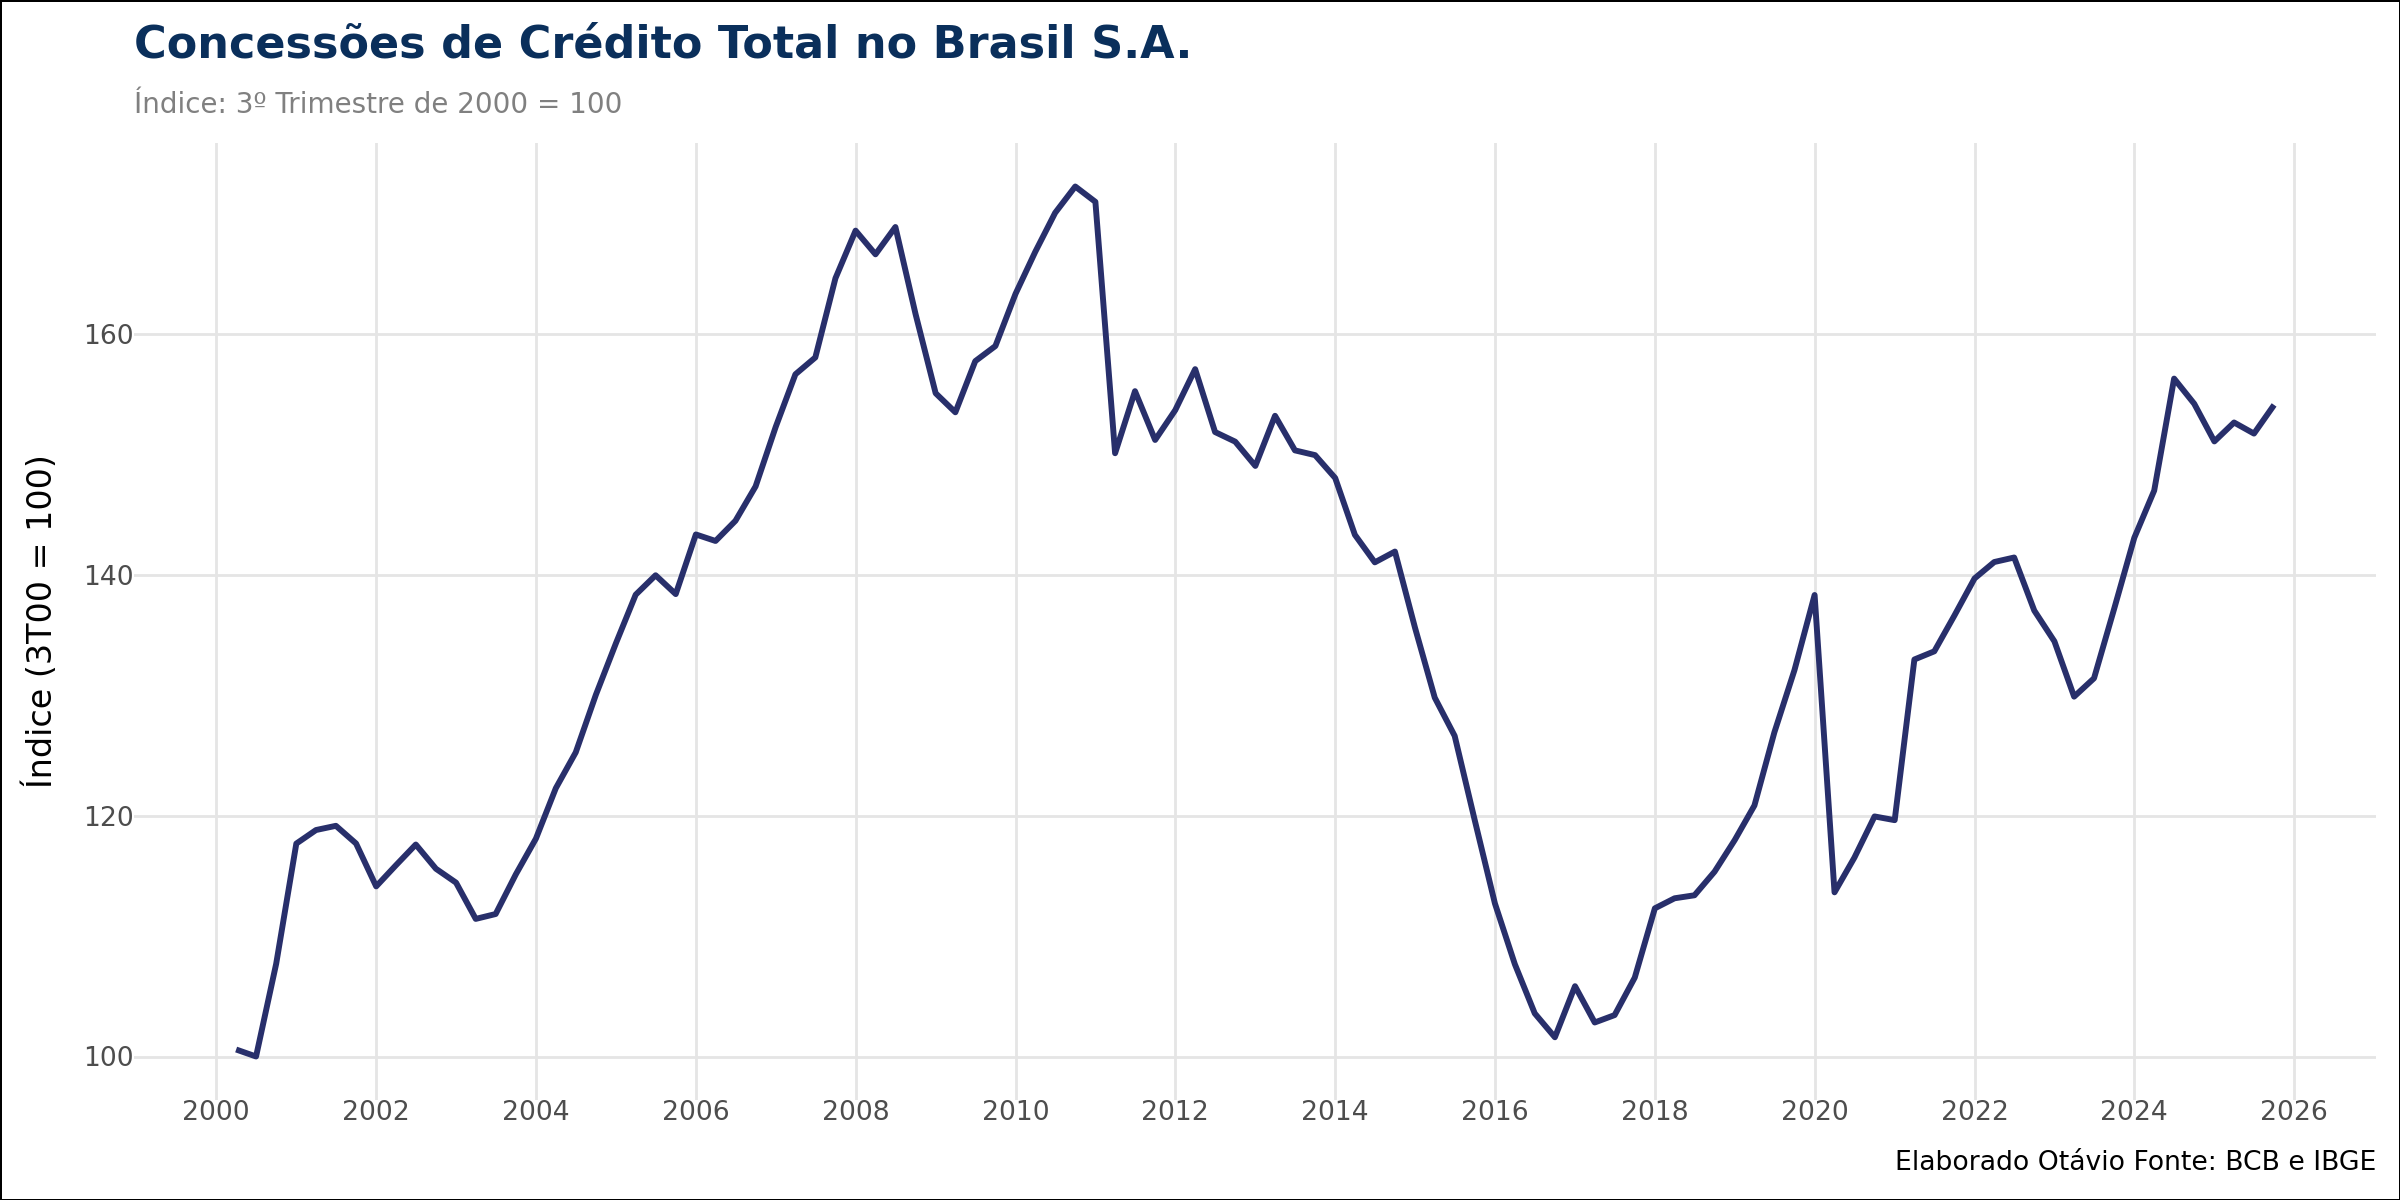

In [ ]:
# Prepara dados para o gráfico
plot_concessoes = concessoes.copy()
plot_concessoes['date'] = plot_concessoes['date_quarter'].dt.to_timestamp()

# Gráfico
g1 = (
    ggplot(plot_concessoes, aes(x="date")) +

    geom_line(aes(y="indice_3t00"), size=1.2, color=cores_am[0]) +

    scale_x_date(date_breaks="2 years", date_labels="%Y") +

    labs(
        title="Concessões de Crédito Total no Brasil S.A.",
        subtitle="Índice: 3º Trimestre de 2000 = 100",
        x="",
        y="Índice (3T00 = 100)",
        color="",
        caption="Elaborado Otávio Fonte: BCB e IBGE"
    ) +

    theme_minimal(base_family="sans", base_size=12) +
    theme(
        plot_title=element_text(face="bold", size=16, color="#0A2F5B"),
        plot_subtitle=element_text(size=10, color="grey"),
        legend_position="top",
        panel_grid_minor=element_blank(),
        figure_size=(12, 6),
        panel_background=element_rect(fill="white"),
        plot_background=element_rect(fill="white")
    )
)

g1

## Hiato BCB

In [ ]:
# Coleta e tratamento do Hiato do Produto do BCB
hiato_bcb = (
    pd.read_excel(
    "https://www.bcb.gov.br/content/ri/relatorioinflacao/202512/rpm202512anp.xlsx",
    sheet_name = "Graf 2.2.8",
    skiprows = 8
    )
    .assign(date_quarter = lambda x: pd.to_datetime(x['Trimestre']).dt.to_period('Q'),
            BCB = lambda x: x["Cenário de referência"].astype(float))
    .loc[:, ['date_quarter', 'BCB']]
    .dropna()
  )

hiato_bcb.head()

,date_quarter,BCB
1,2003Q4,-0.97
2,2004Q1,-0.52
3,2004Q2,-0.10
4,2004Q3,0.28
5,2004Q4,0.50


/usr/local/lib/python3.12/dist-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


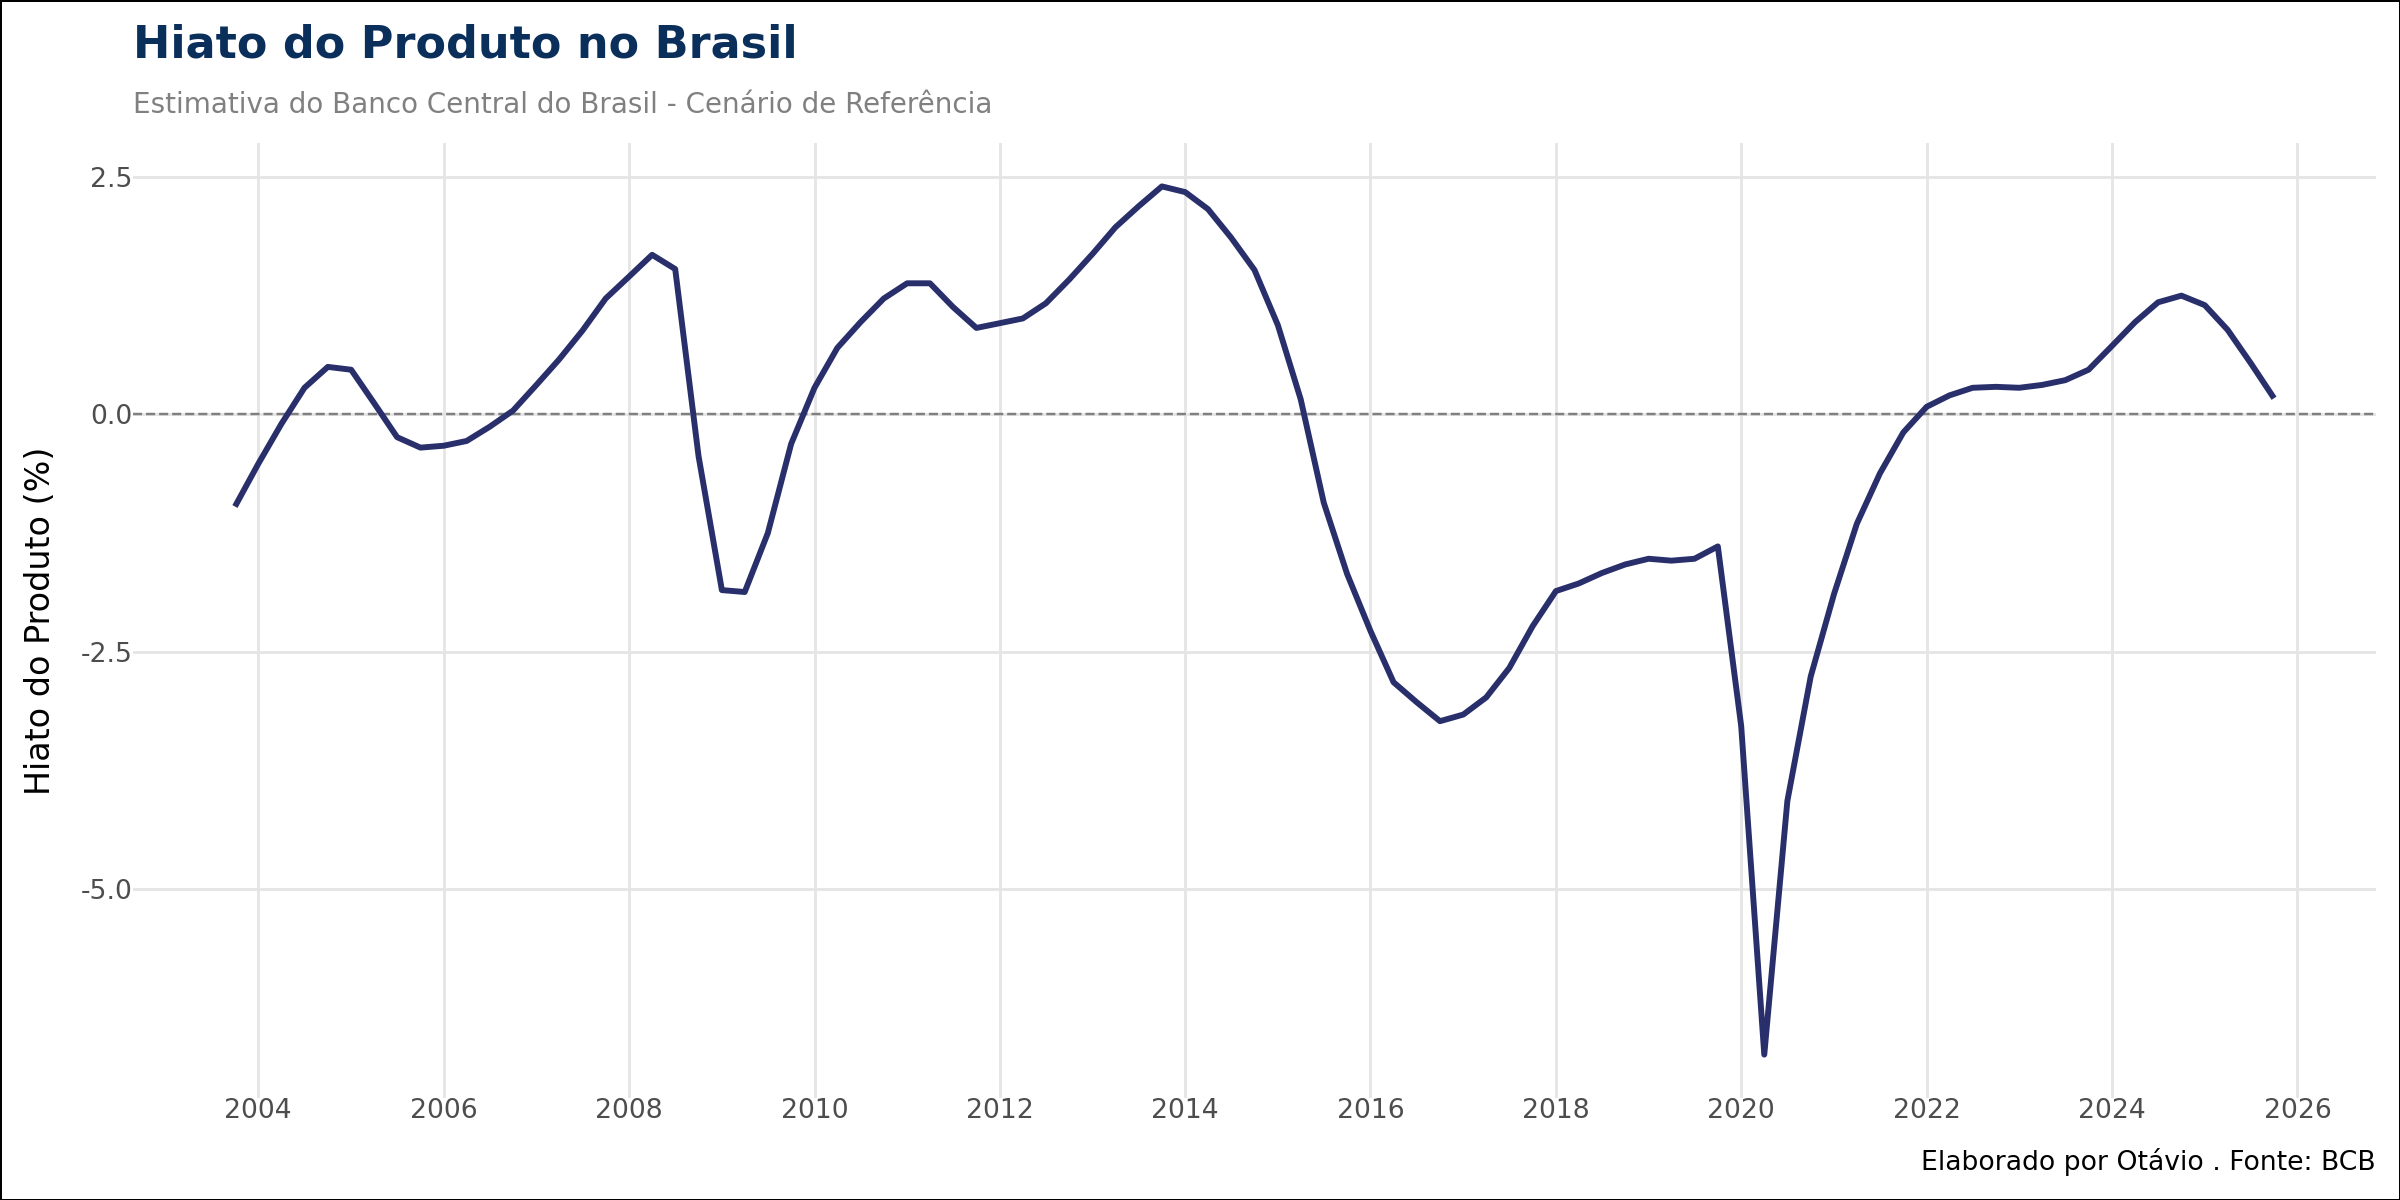

In [ ]:
# Prepara dados para o gráfico
plot_hiato = hiato_bcb.copy()
plot_hiato['date'] = plot_hiato['date_quarter'].dt.to_timestamp()

# Cria Gráfico BCB
g2 = (
    ggplot(plot_hiato, aes(x="date")) +

    geom_hline(yintercept=0, linetype="dashed", color="grey", size=0.5) +

    geom_line(aes(y="BCB"), size=1.2, color=cores_am[0]) +

    scale_x_date(date_breaks="2 years", date_labels="%Y") +

    labs(
        title="Hiato do Produto no Brasil",
        subtitle="Estimativa do Banco Central do Brasil - Cenário de Referência",
        x="",
        y="Hiato do Produto (%)",
        caption="Elaborado por Otávio . Fonte: BCB"
    ) +

    theme_minimal(base_family="sans", base_size=12) +
    theme(
        plot_title=element_text(face="bold", size=16, color="#0A2F5B"),
        plot_subtitle=element_text(size=10, color="grey"),
        legend_position="top",
        panel_grid_minor=element_blank(),
        figure_size=(12, 6),
        panel_background=element_rect(fill="white"),
        plot_background=element_rect(fill="white")
    )
)

g2

## Juro Neutro

In [ ]:
def fisher(juros, inflacao):
    return ((1 + juros/100) / (1 + inflacao/100) - 1) * 100

def reference_date(date, n):
    return (pd.DatetimeIndex(date).year + n).astype(str).tolist()

em = Expectativas()
exp_anual = em.get_endpoint('ExpectativasMercadoAnuais')

# IPCA expectativa t+1
ipca_e_t1 = (
    exp_anual.query()
    .filter(exp_anual.Indicador == "IPCA", exp_anual.baseCalculo == 0)
    .select(exp_anual.Data, exp_anual.Mediana, exp_anual.DataReferencia)
    .collect()
    .query('DataReferencia == @reference_date(Data, 1)')
    .rename(columns={'Data': 'date', 'Mediana': 'ipca_e_t1'})
    .assign(date=lambda x: pd.PeriodIndex(pd.to_datetime(x['date']), freq='M').to_timestamp())
    .groupby('date')['ipca_e_t1'].mean()
    .reset_index()
)

# Selic expectativa t+1
selic_e_t1 = (
    exp_anual.query()
    .filter(exp_anual.Indicador == "Selic", exp_anual.baseCalculo == 0)
    .select(exp_anual.Data, exp_anual.Mediana, exp_anual.DataReferencia)
    .collect()
    .query('DataReferencia == @reference_date(Data, 1)')
    .rename(columns={'Data': 'date', 'Mediana': 'selic_e_t1'})
    .assign(date=lambda x: pd.PeriodIndex(pd.to_datetime(x['date']), freq='M').to_timestamp())
    .groupby('date')['selic_e_t1'].mean()
    .reset_index()
)

# Juro real ex-ante trimestral
juro_real_t1 = (
    ipca_e_t1.merge(selic_e_t1, on='date')
    .assign(
        real_t1=lambda x: fisher(x.selic_e_t1, x.ipca_e_t1),
        date_quarter=lambda x: pd.PeriodIndex(x['date'], freq='Q')
    )
    .groupby('date_quarter')['real_t1'].mean()
    .reset_index(name='real')
)

# Filtro HP para juro neutro
proxy_neutro_hp = (
    pd.DataFrame(sm.tsa.filters.hpfilter(juro_real_t1['real'], lamb=1600)[1])
    .reset_index()
    .rename(columns={'index': 'date_quarter', 'real_trend': 'neutro_hp'})
    .assign(date_quarter=juro_real_t1['date_quarter'].values)
)

# Hiato do juro
hiato_juro = proxy_neutro_hp.merge(juro_real_t1, on='date_quarter').assign(
    hiato=lambda x: x.real - x.neutro_hp
)

hiato_juro.head()

,date_quarter,neutro_hp,real,hiato
0,2000Q1,9.879274,10.476964,0.597690
1,2000Q2,9.784314,10.079362,0.295048
2,2000Q3,9.689727,8.925041,-0.764687
3,2000Q4,9.596072,8.483634,-1.112438
4,2001Q1,9.503429,8.683238,-0.820191


/usr/local/lib/python3.12/dist-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


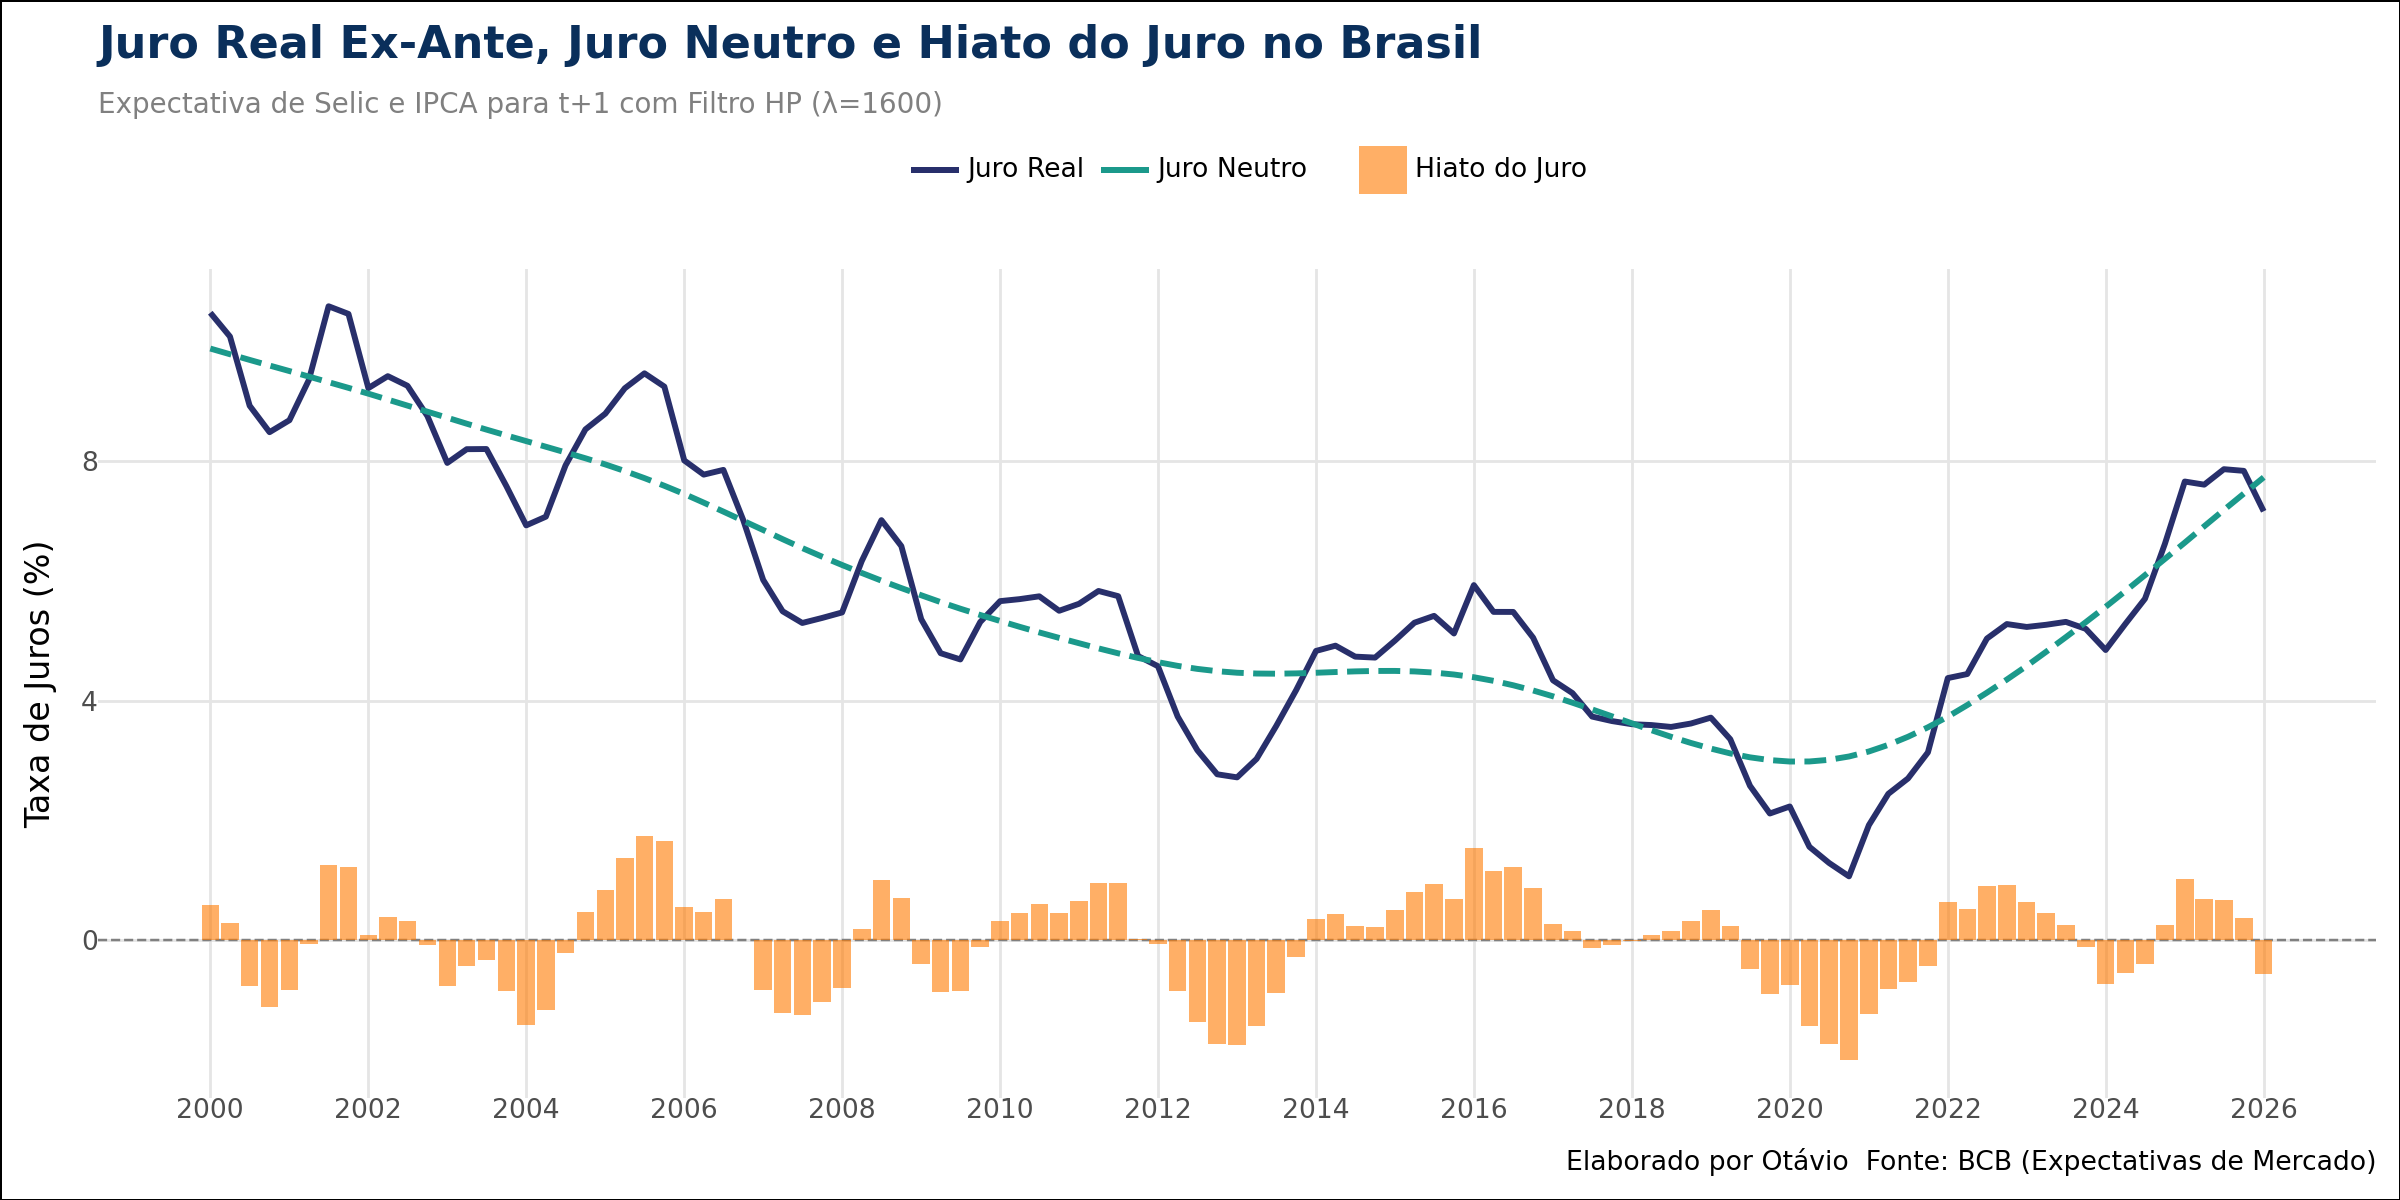

In [ ]:
# Prepara dados para o gráfico
plot_juro = hiato_juro.copy()
plot_juro['date'] = plot_juro['date_quarter'].dt.to_timestamp()

# Reshape para formato longo
plot_juro_long = pd.melt(
    plot_juro,
    id_vars=['date'],
    value_vars=['real', 'neutro_hp', 'hiato'],
    var_name='variavel',
    value_name='valor'
)

# Mapeia nomes das variáveis
plot_juro_long['variavel'] = plot_juro_long['variavel'].map({
    'real': 'Juro Real',
    'neutro_hp': 'Juro Neutro',
    'hiato': 'Hiato do Juro'
})

# Gráfico
g3 = (
    ggplot(plot_juro_long, aes(x="date", y="valor")) +

    geom_hline(yintercept=0, linetype="dashed", color="grey", size=0.5) +

    geom_col(
        data=plot_juro_long[plot_juro_long['variavel'] == 'Hiato do Juro'],
        mapping=aes(fill="variavel"),
        alpha=0.6
    ) +

    geom_line(
        data=plot_juro_long[plot_juro_long['variavel'] == 'Juro Real'],
        mapping=aes(color="variavel"),
        size=1.2
    ) +

    geom_line(
        data=plot_juro_long[plot_juro_long['variavel'] == 'Juro Neutro'],
        mapping=aes(color="variavel"),
        size=1.2,
        linetype="dashed"
    ) +

    scale_color_manual(
        values={
            "Juro Real": cores_am[0],
            "Juro Neutro": cores_am[1]
        }
    ) +

    scale_fill_manual(
        values={
            "Hiato do Juro": cores_am[2]
        }
    ) +

    scale_x_date(date_breaks="2 years", date_labels="%Y") +

    labs(
        title="Juro Real Ex-Ante, Juro Neutro e Hiato do Juro no Brasil",
        subtitle="Expectativa de Selic e IPCA para t+1 com Filtro HP (λ=1600)",
        x="",
        y="Taxa de Juros (%)",
        color="",
        fill="",
        caption="Elaborado por Otávio  Fonte: BCB (Expectativas de Mercado)"
    ) +

    theme_minimal(base_family="sans", base_size=12) +
    theme(
        plot_title=element_text(face="bold", size=16, color="#0A2F5B"),
        plot_subtitle=element_text(size=10, color="grey"),
        legend_position="top",
        panel_grid_minor=element_blank(),
        figure_size=(12, 6),
        panel_background=element_rect(fill="white"),
        plot_background=element_rect(fill="white")
    )
)

g3

## Ciclo das Concessões de Crédito

In [ ]:
# Junta os Dados
df = (
    concessoes
        .merge(hiato_bcb, on="date_quarter", how="left")
        .merge(hiato_juro, on="date_quarter", how="left")
)

df.head()

,date_quarter,deflacionado_total,ajuste_total,indice_3t00,log_indice,BCB,neutro_hp,real,hiato
0,2000Q2,237951.429959,237.409453,100.580796,4.610961,NaN,9.784314,10.079362,0.295048
1,2000Q3,235614.908879,236.038551,100.000000,4.605170,NaN,9.689727,8.925041,-0.764687
2,2000Q4,263813.406986,254.233632,107.708521,4.679429,NaN,9.596072,8.483634,-1.112438
3,2001Q1,268136.946107,277.803719,117.694214,4.768090,NaN,9.503429,8.683238,-0.820191
4,2001Q2,280990.555683,280.460868,118.819941,4.777609,NaN,9.411182,9.356288,-0.054894


In [ ]:
# Filtro HP das concessões
filtro_hp_concessoes = sm.tsa.filters.hpfilter(df['log_indice'], lamb=1600)
df = df.assign(
    concessoes_ciclo=filtro_hp_concessoes[0] * 100, # retira ciclo e multiplica por 100
    concessoes_tendencia=filtro_hp_concessoes[1] # retira tendência
)

df.head()

,date_quarter,deflacionado_total,ajuste_total,indice_3t00,log_indice,BCB,neutro_hp,real,hiato,concessoes_ciclo,concessoes_tendencia
0,2000Q2,237951.429959,237.409453,100.580796,4.610961,NaN,9.784314,10.079362,0.295048,-4.298869,4.653950
1,2000Q3,235614.908879,236.038551,100.000000,4.605170,NaN,9.689727,8.925041,-0.764687,-6.028592,4.665456
2,2000Q4,263813.406986,254.233632,107.708521,4.679429,NaN,9.596072,8.483634,-1.112438,0.249339,4.676935
3,2001Q1,268136.946107,277.803719,117.694214,4.768090,NaN,9.503429,8.683238,-0.820191,7.976676,4.688323
4,2001Q2,280990.555683,280.460868,118.819941,4.777609,NaN,9.411182,9.356288,-0.054894,7.805276,4.699556


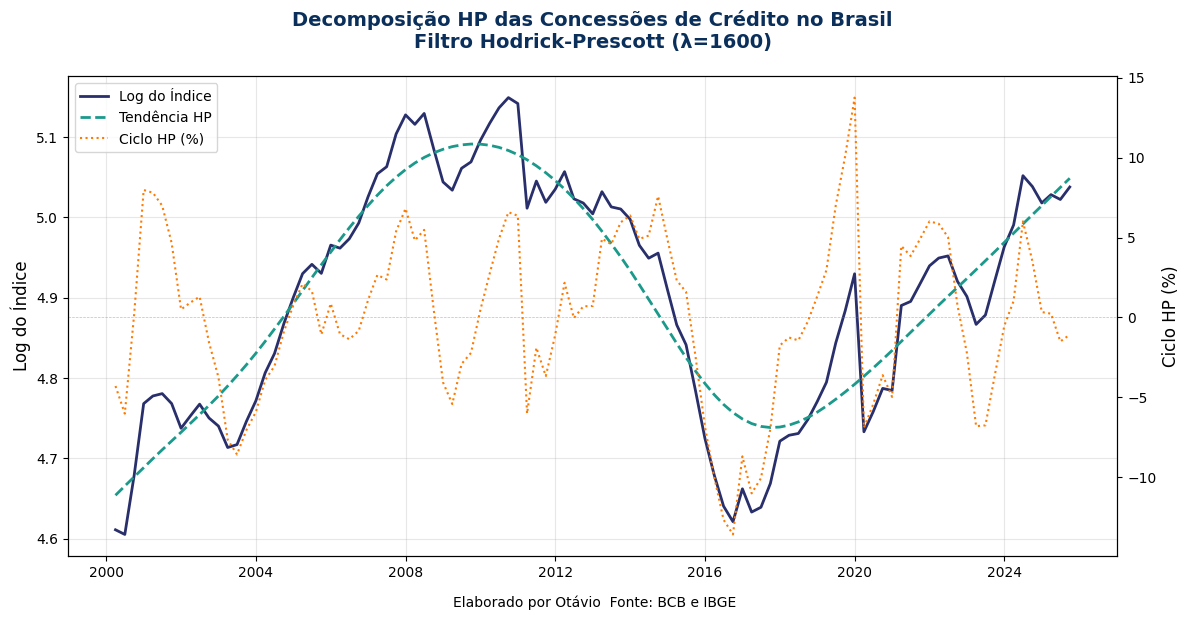

In [ ]:
import matplotlib.pyplot as plt

# Prepara dados
plot_concessoes_hp = df.copy()
plot_concessoes_hp['date'] = plot_concessoes_hp['date_quarter'].dt.to_timestamp()

# Cria figura e eixos
fig, ax1 = plt.subplots(figsize=(12, 6))

# Eixo primário (log_indice e tendência)
ax1.plot(plot_concessoes_hp['date'], plot_concessoes_hp['log_indice'],
         color=cores_am[0], linewidth=2, label='Log do Índice')
ax1.plot(plot_concessoes_hp['date'], plot_concessoes_hp['concessoes_tendencia'],
         color=cores_am[1], linewidth=2, linestyle='--', label='Tendência HP')
ax1.set_xlabel('')
ax1.set_ylabel('Log do Índice', fontsize=12)
ax1.tick_params(axis='y')
ax1.grid(True, alpha=0.3)

# Eixo secundário (ciclo)
ax2 = ax1.twinx()
ax2.plot(plot_concessoes_hp['date'], plot_concessoes_hp['concessoes_ciclo'],
         color=cores_am[2], linewidth=1.5, linestyle=':', label='Ciclo HP (%)')
ax2.set_ylabel('Ciclo HP (%)', fontsize=12)
ax2.axhline(y=0, linestyle='dashed', color='grey', linewidth=0.5, alpha=0.5)
ax2.tick_params(axis='y')

# Legendas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Título
plt.title('Decomposição HP das Concessões de Crédito no Brasil\nFiltro Hodrick-Prescott (λ=1600)',
          fontsize=14, fontweight='bold', color='#0A2F5B', pad=20)

# Caption corrigido
fig.text(0.5, -0.02, 'Elaborado por Otávio  Fonte: BCB e IBGE',
         ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

## Modelagem

Na etapa final, o código estrutura uma análise de regressão para explicar o **Ciclo de Concessões de Crédito**. Foram testadas diversas especificações de modelos lineares, utilizando como variáveis explicativas:

*   O **Hiato do Produto** (atividade econômica).

*   O **Hiato de Juros** (política monetária).

*   Defasagens (*lags*) de 1 e 2 trimestres dessas variáveis.

A teoria econômica sugere — e o exercício busca confirmar — que o ciclo de crédito possui uma correlação positiva com o hiato do produto (atividade forte gera demanda por crédito) e uma correlação negativa com o hiato de juros (juros acima do neutro encarecem e contraem o crédito). A utilização de defasagens é crucial, pois o efeito da política monetária sobre o crédito não é imediato, operando através de canais de transmissão que levam tempo para se materializar.

In [ ]:
# Remove valores nulos
df_reg = df.dropna().copy()

# Cria defasagens
for lag in [1, 2]:
    df_reg[f'BCB_L{lag}'] = df_reg['BCB'].shift(lag)
    df_reg[f'hiato_L{lag}'] = df_reg['hiato'].shift(lag)

df_reg.dropna(inplace=True)

# Define combinações de modelos (até 2 defasagens)
formulas = [
    'concessoes_ciclo ~ BCB + hiato',
    'concessoes_ciclo ~ BCB + BCB_L1 + hiato + hiato_L1',
    'concessoes_ciclo ~ BCB + BCB_L1 + BCB_L2 + hiato + hiato_L1 + hiato_L2',
    'concessoes_ciclo ~ BCB + hiato + hiato_L1',
    'concessoes_ciclo ~ BCB + BCB_L1 + hiato',
]

# Estima modelos
modelos = []
for formula in formulas:
    modelo = smf.ols(formula, data=df_reg).fit(cov_type='HC3')
    modelos.append(modelo)

In [ ]:
# Cria tabela com Stargazer
stargazer = Stargazer(modelos)
stargazer.title('Regressão do Hiato das Concessões de Crédito')
stargazer.custom_columns(['(1)', '(2)', '(3)', '(4)', '(5)'], [1, 1, 1, 1, 1])
stargazer.covariate_order(['Intercept', 'BCB', 'BCB_L1', 'BCB_L2', 'hiato', 'hiato_L1', 'hiato_L2'])
stargazer.rename_covariates({
    'Intercept': 'Constante',
    'BCB': 'Hiato Produto',
    'BCB_L1': 'Hiato Produto (t-1)',
    'BCB_L2': 'Hiato Produto (t-2)',
    'hiato': 'Hiato Juro',
    'hiato_L1': 'Hiato Juro (t-1)',
    'hiato_L2': 'Hiato Juro (t-2)'
})

stargazer.show_model_numbers(False)
stargazer

## Referências

Referências Bibliográficas
BANCO CENTRAL DO BRASIL. Boxe 3: Ciclos de crédito e de negócios. In: Relatório de Inflação: junho 2023. Brasília: BCB, 2023. Disponível em: https://www.bcb.gov.br/content/ri/relatorioinflacao/202306/ri202306b3p.pdf. Acesso em: 14 jan. 2026.